# 31 sync.WaitGroup和sync.Once

在前面几节中讲的互斥锁，条件变量和原子操作都是最基本重要的同步工具。在go语言中，除了通道chanle以外，这些都算是最为常用的并发安全工具。

说到通道，不知道你想过没有，之前在一些场合下里，我们使用通道的方式看起来都似乎有些蹩脚。

比如：**声明一个通道，使它的容量与我们手动启用的goroutine的数量相同，之后再利用这个通道，让主goroutine等待其他goroutine的运行结束。**

这一步更具体地说就是：让其他的goroutine在运行结束之前，都向这个通道发送一个元素值，并且，让主goroutine在最后从这个通道中接收元素值，接收的次数需要与其他的goroutine的数量相同。

这就是下面的coordinateWithChan函数展示的多goroutine协作流程。


In [ ]:
func coordinateWithChan() {
 sign := make(chan struct{}, 2)
 num := int32(0)
 fmt.Printf("The number: %d [with chan struct{}]\n", num)
 max := int32(10)
 go addNum(&num, 1, max, func() {
  sign <- struct{}{}
 })
 go addNum(&num, 2, max, func() {
  sign <- struct{}{}
 })
 <-sign
 <-sign
}

其中的`addNum`函数的声明在demo65.go文件中。`addNum`函数会把它接受的最后一个参数值作为其中的`defer`函数。

我手动启用的两个`goroutine`都会调用`addNum`函数，而它们传给该函数的最后一个参数值（也就是那个既无参数声明，也无结果声明的函数）都只会做一件事情，那就是向通道`sign`发送一个元素值。

看到`coordinateWithChan`函数中最后的那两行代码了吗？重复的两个接收表达式`<-sign`，是不是看起来很丑陋？

## 前导内容：sync包的`WaitGrop`类型

其实，在这种应用场景下，我们可以选用另外一个同步工具，即：`sync`包的`WaitGroup`类型。它比通道更加适合实现这种**一对多**的`goroutine`协作流程。

`sync.WaitGroup`类型（以下简称WaitGroup类型）是开箱即用的，也是并发安全的。同时，与我们前面讨论的几个同步工具一样，它一旦被真正使用就不能被复制了。

`WaitGroup`类型拥有三个指针方法：`Add`、`Done`和`Wait`。你可以想象该类型中有一个计数器，它的默认值是0。我们可以通过调用该类型值的`Add`方法来增加，或者减少这个计数器的值。

一般情况下，我会用这个方法来记录需要等待的`goroutine`的数量。相对应的，这个类型的`Done`方法，用于对其所属值中计数器的值进行减一操作。我们可以在需要等待的`goroutine`中，通过`defer`语句调用它。

而此类型的`Wait`方法的功能是，**阻塞当前的goroutine**，直到其所属值中的计数器归零。如果在该方法被调用的时候，那个计数器的值就是0，那么它将不会做任何事情。

你可能已经看出来了，WaitGroup类型的值（以下简称WaitGroup值）完全可以被用来替换`coordinateWithChan`函数中的通道sign。下面的`coordinateWithWaitGroup`函数就是它的**改造版本**。

In [ ]:
func coordinateWithWaitGroup() {
 var wg sync.WaitGroup
 wg.Add(2)
 num := int32(0)
 fmt.Printf("The number: %d [with sync.WaitGroup]\n", num)
 max := int32(10)
 go addNum(&num, 3, max, wg.Done)
 go addNum(&num, 4, max, wg.Done)
 wg.Wait() // 阻塞coordinateWithWaitGroup，直到wg计数器归零
}

很明显，整体代码少了好几行，而且看起来也更加简洁了。这里我先声明了一个`WaitGroup`类型的变量`wg`。然后，我调用了它的`Add`方法并传入了2，因为我会在后面启用两个需要等待的`goroutine`。

由于`wg`变量的`Done`方法本身就是一个既无参数声明，也无结果声明的函数，所以我在`go`语句中调用`addNum`函数的时候，可以直接把该方法作为最后一个参数值传进去。

在`coordinateWithWaitGroup`函数的最后，我调用了`wg`的`Wait`方法。如此一来，该函数就可以等到那两个`goroutine`都运行结束之后，再结束执行了。

以上就是`WaitGroup`类型最典型的应用场景了。不过不能止步于此，对于这个类型，我们还是有必要再深入了解一下的。我们一起看下面的问题。

**问题：`sync.WaitGroup`类型值中计数器的值可以小于`0`吗**？

这里的典型回答是：不可以。

## 问题解析

为什么不可以呢，我们解析一下。**之所以说`WaitGroup`值中计数器的值不能小于`0`，是因为这样会引发一个`panic`**。 不适当地调用这类值的`Done`方法和`Add`方法都会如此。别忘了，我们在调用`Add`方法的时候是可以传入一个负数的。

实际上，导致`WaitGroup`值的方法抛出`panic`的原因不只这一种。

你需要知道，在我们声明了这样一个变量之后，应该首先根据需要等待的`goroutine`，或者其他事件的数量，调用它的`Add`方法，以使计数器的值大于`0`。这是确保我们能在后面正常地使用这类值的前提。

如果我们对它的`Add`方法的首次调用，与对它的`Wait`方法的调用是同时发起的，比如，在同时启用的两个`goroutine`中，分别调用这两个方法，那么就有可能会让这里的`Add`方法抛出一个`panic`。

这种情况不太容易复现，也正因为如此，我们更应该予以重视。所以，虽然`WaitGroup`值本身并不需要初始化，但是尽早地增加其计数器的值，还是非常有必要的。

另外，你可能已经知道，`WaitGroup`值是可以被复用的，但需要保证其计数周期的完整性。这里的计数周期指的是这样一个过程：该值中的计数器值由`0`变为了某个正整数，而后又经过一系列的变化，最终由某个正整数又变回了`0`。

也就是说，只要计数器的值始于`0`又归为`0`，就可以被视为一个计数周期。在一个此类值的生命周期中，它可以经历任意多个计数周期。但是，只有在它走完当前的计数周期之后，才能够开始下一个计数周期。

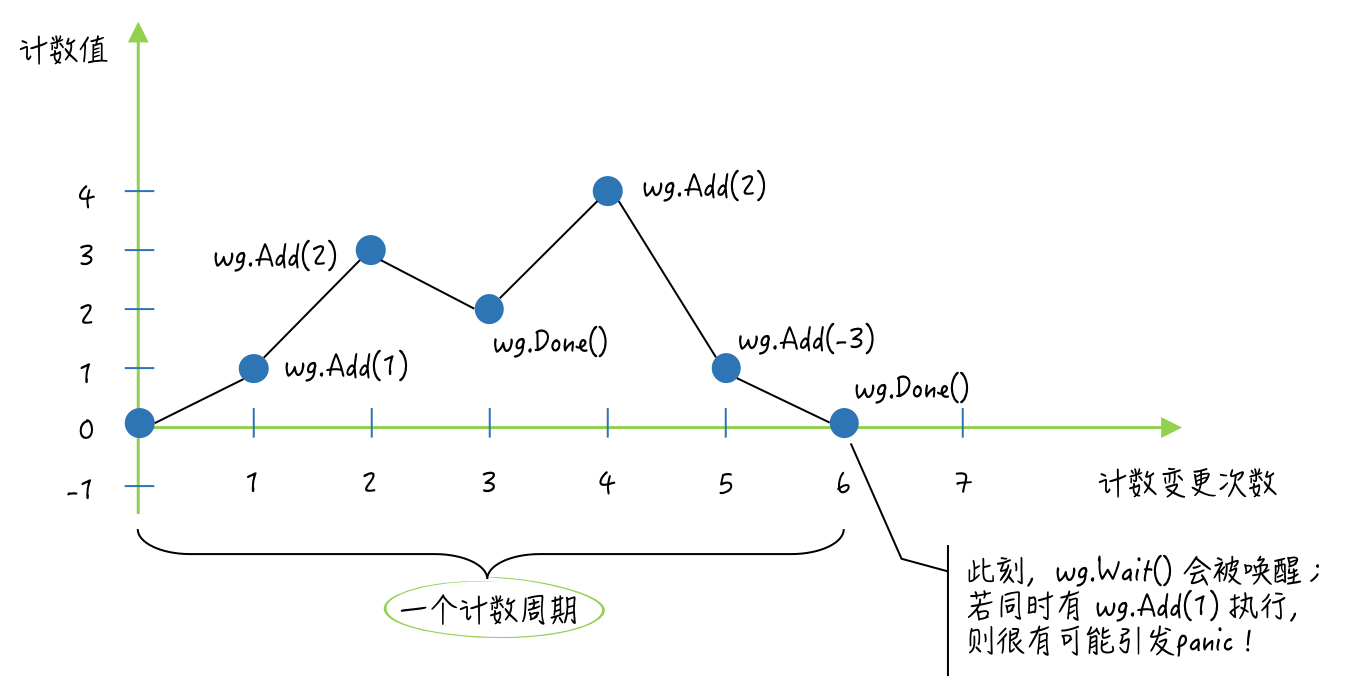


因此，也可以说，如果一个此类值的`Wait`方法在它的某个计数周期中被调用，那么就会立即阻塞当前的`goroutine`，直至这个计数周期完成。在这种情况下，该值的下一个计数周期，必须要等到这个`Wait`方法执行结束之后，才能够开始。

如果在一个此类值的`Wait`方法被执行期间，跨越**了两个计数周期**，那么就会引发一个`panic`。

例如，在当前的`goroutine`因调用此类值的`Wait`方法，而被阻塞的时候，另一个`goroutine`调用了该值的`Done`方法，并使其计数器的值变为了`0`。

这会唤醒当前的`goroutine`，并使它试图继续执行`Wait`方法中其余的代码。但在这时，又有一个`goroutine`调用了它的`Add`方法，并让其计数器的值又从0变为了某个正整数。此时，这里的`Wait`方法就会立即抛出一个`panic`。

纵观上述会引发`panic`的后两种情况，我们可以总结出这样一条关于`WaitGroup`值的使用禁忌，即：**不要把增加其计数器值的操作和调用其`Wait`方法的代码，放在不同的`goroutine`中执行。换句话说，要杜绝对同一个`WaitGroup`值的两种操作的并发执行。**

除了第一种情况外，我们通常需要反复地实验，才能够让`WaitGroup`值的方法抛出`panic`。再次强调，虽然这不是每次都发生，但是在长期运行的程序中，这种情况发生的概率还是不小的，我们必须要重视它们。

如果你对复现这些异常情况感兴趣，那么可以参看`sync`代码包中的`waitgroup_test.go`文件。其中的名称以`TestWaitGroupMisuse`为前缀的测试函数，很好地展示了这些异常情况的发生条件。你可以模仿这些测试函数自己写一些测试代码，执行一下试试看。

## 知识扩展
**问题：`sync.Once`类型值的`Do`方法是怎么保证只执行参数函数一次的？**

与`sync.WaitGroup`类型一样，`sync.Once`类型（以下简称Once类型）也属于结构体类型，同样也是开箱即用和并发安全的。由于这个类型中包含了一个`sync.Mutex`类型的字段，所以，复制该类型的值也会导致功能的失效。

`Once`类型的`Do`方法只接受一个参数，这个参数的类型必须是`func()`，即：无参数声明和结果声明的函数。

该方法的功能并不是对每一种参数函数都只执行一次，而是**只执行“首次被调用时传入的”那个函数，并且之后不会再执行任何参数函数。**

所以，如果你有多个只需要执行一次的函数，那么就应该为它们中的每一个都分配一个`sync.Once`类型的值（以下简称`Once`值）。

`Once`类型中还有一个名叫`done`的`uint32`类型的字段。它的作用是记录其所属值的`Do`方法被调用的次数。不过，该字段的值只可能是`0`或者`1`。一旦`Do`方法的首次调用完成，它的值就会从`0`变为`1`。

你可能会问，既然`done`字段的值不是`0`就是`1`，那为什么还要使用需要四个字节的`uint32`类型呢？

原因很简单，因为对它的操作必须是“原子”的。`Do`方法在一开始就会通过调用`atomic.LoadUint32`函数来获取该字段的值，并且一旦发现该值为`1`，就会直接返回。这也初步保证了“`Do`方法，只会执行首次被调用时传入的函数”。

不过，单凭这样一个判断的保证是不够的。因为，如果有两个`goroutine`都调用了同一个新的`Once`值的`Do`方法，并且几乎同时执行到了其中的这个条件判断代码，那么它们就都会因判断结果为`false`，而继续执行`Do`方法中剩余的代码。

在这个条件判断之后，`Do`方法会立即锁定其所属值中的那个`sync.Mutex`类型的字段`m`。然后，它会在**临界区**中再次检查`done`字段的值，并且仅在条件满足时，才会去调用参数函数，以及用原子操作把`done`的值变为`1`。

如果你熟悉`GoF`设计模式中的单例模式的话，那么肯定能看出来，这个`Do`方法的实现方式，与那个单例模式有很多相似之处。它们都会先在临界区之外，判断一次关键条件，若条件不满足则立即返回。这通常被称为“快路径”，或者叫做“快速失败路径”。

如果条件满足，那么到了临界区中还要再对关键条件进行一次判断，这主要是为了更加严谨。这两次条件判断常被统称为（跨临界区的）“双重检查”。

由于进入临界区之前，肯定要锁定保护它的互斥锁`m`，显然会降低代码的执行速度，所以其中的第二次条件判断，以及后续的操作就被称为“慢路径”或者“常规路径”。

别看`Do`方法中的代码不多，但它却应用了一个很经典的编程范式。我们在Go语言及其标准库中，还能看到不少这个经典范式及它衍生版本的应用案例。

下面我再来说说这个`Do`方法在功能方面的两个特点。

1. 第一个特点，由于`Do`方法只会在参数函数执行结束之后把`done`字段的值变为`1`，因此，如果参数函数的执行需要很长时间或者根本就不会结束（比如执行一些守护任务），那么就有可能会导致相关`goroutine`的同时阻塞。

例如，有多个`goroutine`并发地调用了同一个`Once`值的`Do`方法，并且传入的函数都会一直执行而不结束。那么，这些`goroutine`就都会因调用了这个`Do`方法而阻塞。因为，除了那个抢先执行了参数函数的`goroutine`之外，其他的`goroutine`都会被阻塞在锁定该`Once`值的互斥锁`m`的那行代码上。

2. 第二个特点，`Do`方法在参数函数执行结束后，对`done`字段的赋值用的是原子操作，并且，这一操作是被挂在`defer`语句中的。因此，不论参数函数的执行会以怎样的方式结束，`done`字段的值都会变为`1`。

也就是说，即使这个参数函数没有**执行成功（比如引发了一个panic）**，我们也无法使用同一个`Once`值重新执行它了。所以，如果你需要为参数函数的执行设定重试机制，那么就要考虑`Once`值的适时替换问题。

在很多时候，我们需要依据`Do`方法的这两个特点来设计与之相关的流程，以避免不必要的程序阻塞和功能缺失。

## 总结
`sync`代码包的`WaitGroup`类型和`Once`类型都是非常易用的同步工具。它们都是开箱即用和并发安全的。

利用`WaitGroup`值，我们可以很方便地实现**一对多**的`goroutine`协作流程，**即：一个分发子任务的`goroutine`，和多个执行子任务的`goroutine`，共同来完成一个较大的任务。**

在使用`WaitGroup`值的时候，我们一定要注意，千万不要让其中的计数器的值小于`0`，否则就会引发`panic`。

另外，我们最好用“**先统一`Add`，再并发`Done`，最后`Wait`”这种标准方式，来使用`WaitGroup`值**.尤其不要在调用`Wait`方法的同时，并发地通过调用`Add`方法去增加其计数器的值，因为这也有可能引发`panic`。

`Once`值的使用方式比`WaitGroup`值更加简单，它只有一个`Do`方法。同一个Once值的Do方法，永远只会执行第一次被调用时传入的参数函数，不论这个函数的执行会以怎样的方式结束。

只要传入某个`Do`方法的参数函数没有结束执行，任何之后调用该方法的`goroutine`就都会被阻塞。只有在这个参数函数执行结束以后，那些`goroutine`才会逐一被唤醒。

`Once`类型使用互斥锁和原子操作实现了功能，而`WaitGroup`类型中只用到了原子操作。 所以可以说，它们都是更高层次的同步工具。它们都基于基本的通用工具，实现了某一种特定的功能。`sync`包中的其他高级同步工具，其实也都是这样的。

## 思考题
今天的思考题是：在使用WaitGroup值实现一对多的goroutine协作流程时，怎样才能让分发子任务的goroutine获得各个子任务的具体执行结果？

方案一：使用 Channel 来汇总结果（推荐）
这是 Go 语言中最惯用（idiomatic）的方法。channel 天生就是用来在 goroutine 之间安全传递数据的。

思路：

1. 创建一个 WaitGroup (用于等待)。

2. 创建一个 channel (用于接收结果)。

3. 主 goroutine 启动 N 个子 goroutine。

4. 每个子 goroutine 执行任务，将结果推入 channel，然后调用 wg.Done()。

5. 主 goroutine 等待所有结果。

关键点： 主 goroutine 如何知道何时“停止”从 channel 接收结果？

这里有一个非常优雅的模式：启动一个专门的“等待 goroutine” 来关闭 channel。